# Super Store Time Series

Import Packages

In [50]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [51]:
df = pd.read_csv("C:\\Users\\water\\OneDrive - North Carolina State University\\MSA\\07_Data_Code_Competitions\\Superstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [52]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture['Order Date'].min(), furniture['Order Date'].max()


(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [53]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [54]:
furniture = furniture.groupby('Order Date')["Sales"].sum().reset_index()

In [55]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Resamples the Data such that month is the new bottom denominator

In [56]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

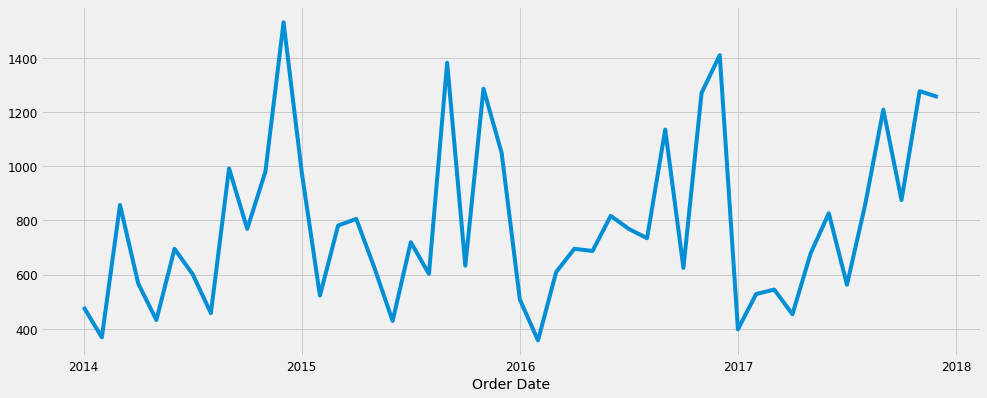

In [57]:
y.plot(figsize=(15,6))
plt.show()

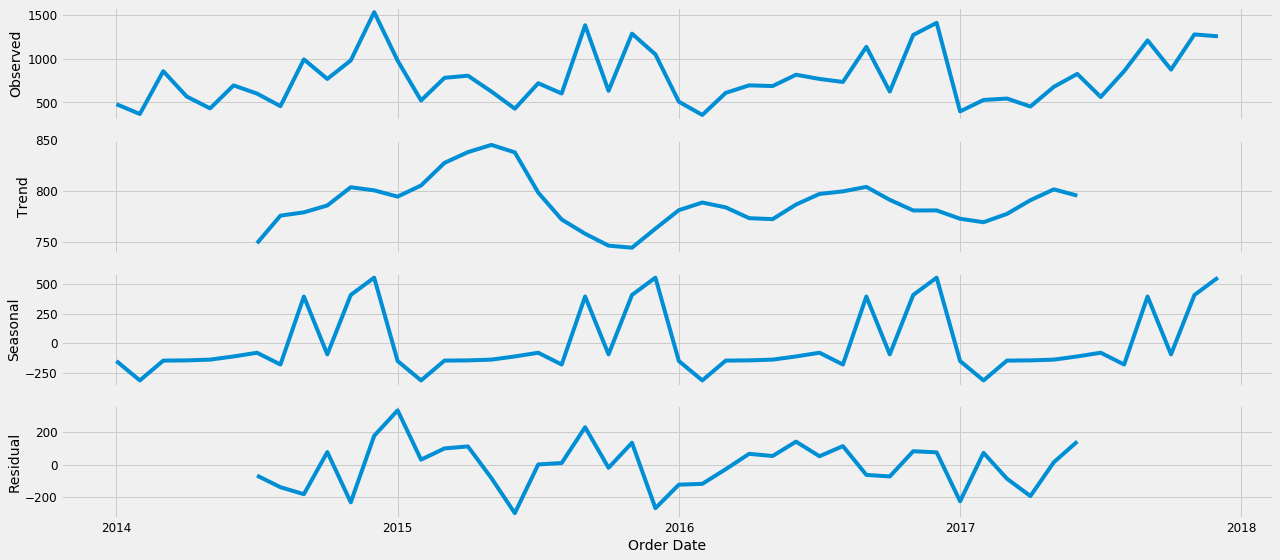

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Showing unstable (No White Noise) therefore ARIMA modeling is required

In [59]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [60]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Goal now is to use the combinations above to performa grid search to find the optimal set of paramters that yields best model performance.

In [77]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,                                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1558.2072802639495
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183377
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1227.9114047320836
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758127
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2992.392138074685
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091374
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5385424657146
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:7664.762184915648
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1329.473779254996
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1372.9654503444347
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817033
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3136.4044382112056
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548483002
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442624
ARIM

In [78]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (1,1,1),
                                seasonal_order = (1,1,0,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


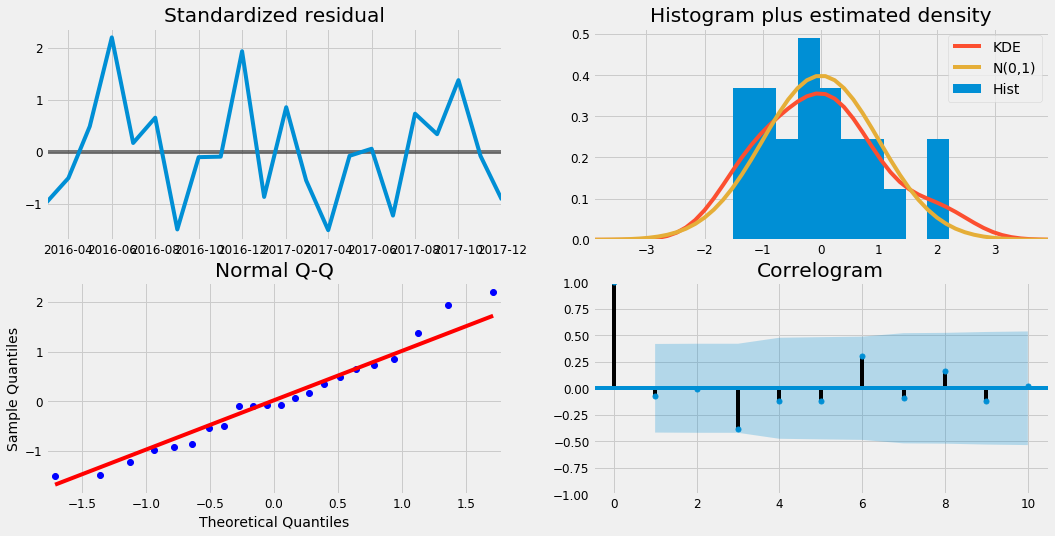

In [80]:
results.plot_diagnostics(figsize=(16,8))
plt.show()